# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [10]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [14]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.303139, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302289, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302183, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302143, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302380, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303269, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301594, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302052, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302268, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302424, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.302773, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302187, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302455, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302688, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301814, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301626, Train acc

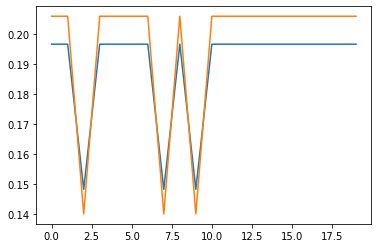

In [15]:
plt.plot(train_history)
plt.plot(val_history)

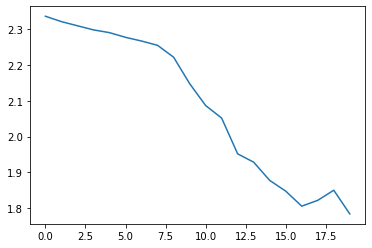

In [20]:
plt.plot(loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [16]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.288748, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263749, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.230533, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261062, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276708, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280981, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258809, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.423836, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.184394, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259841, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311260, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262605, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248855, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263703, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.386262, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273989, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [17]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.320441, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306046, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314545, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311941, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307131, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310947, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293194, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274361, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316933, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298599, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289553, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243401, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.282653, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259952, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.323000, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [18]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.334834, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.312131, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333271, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.294065, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303965, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.234336, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.349652, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.261420, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.196440, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.316239, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.860061, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.021359, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.178519, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.862333, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.279254, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.169076, Train acc

Loss: 1.045923, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.382928, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.122145, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 1.237052, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.410154, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.362168, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.249234, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.298005, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.070719, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.135429, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.443530, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.240980, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.501325, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.265618, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.498467, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.407925, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [24]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=200, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.339551, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.312592, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.321773, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.331201, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.308350, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.271125, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.279685, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.246947, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.116949, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.961081, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.322461, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.898869, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.166326, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.126857, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.294244, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.934189, Train acc

Loss: 1.678476, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.359914, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.475170, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.175276, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.229177, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.322708, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.110534, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.281835, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.475421, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.415768, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.222506, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.340799, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.261167, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.285853, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.430879, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.290391, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [36]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-2, 1e-1]
reg_strengths = [1e-3, 1e-2]
learning_rate_decay = [0.9, 0.99]
hidden_layer_sizes = [128, 256]
num_epochs = [100]
batch_sizes = [64]

best_classifier = None
best_val_accuracy = None


loss_history = []
train_history = []
val_history = []

In [37]:
# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
cntr = 1


for rate in learning_rates:
    print(f"\n============Loop # {cntr}...============")
    for strength in reg_strengths:
        for hidden_layer_size in hidden_layer_sizes:
            for epochs in num_epochs:
                for batch_size in batch_sizes:
                    
                    

                    classifier = TwoLayerNet(n_input = train_X.shape[1],
                                       n_output = 10,
                                       hidden_layer_size = hidden_layer_size,
                                       reg = strength)

                    dataset = Dataset(train_X, train_y, val_X, val_y)

                    trainer = Trainer(classifier, dataset, MomentumSGD(), 
                                      learning_rate=rate, 
                                      num_epochs = epochs,
                                      batch_size=batch_size)

                    loss_history, train_history, val_history = trainer.fit()
                    
                    print('==========\nlearning rate =', rate, 
                          'reg =', strength, 
                          'accuracy =', val_history[-1], 
                          'number of epochs =', epochs,
                          'batch size =', batch_size,
                          'hidden layer size =', batch_size,
                          
                          '\n==========')
                    accuracy = val_history[-1]
                    if best_val_accuracy is None or accuracy > best_val_accuracy:
                        best_val_accuracy = accuracy
                        best_classifier = classifier
                        best_learning_rate = rate
                        best_reg_strength = strength
                        best_batch_size = batch_size
                        best_num_epochs = epochs
                        best_hidden_layer_size = hidden_layer_size
                        
                    # нужно сделать функцию для простановки значений, а то дубляж кода
#                     if accuracy > best_val_accuracy:
#                         best_val_accuracy = accuracy
#                         best_classifier = classifier
#                         best_learning_rate = rate
#                         best_reg_strength = strength
#                         best_batch_size = batch_size
#                         best_num_epochs = epochs
#                         best_hidden_layer_size = hidden_layer_size

    cntr += 1


============Loop # 1...============
Loss: 2.260030, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.167200, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.131089, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.156050, Train accuracy: 0.230333, val accuracy: 0.239000
Loss: 2.084240, Train accuracy: 0.264889, val accuracy: 0.263000
Loss: 2.015680, Train accuracy: 0.285778, val accuracy: 0.291000
Loss: 1.997574, Train accuracy: 0.347444, val accuracy: 0.361000
Loss: 2.065907, Train accuracy: 0.392111, val accuracy: 0.377000
Loss: 1.788769, Train accuracy: 0.438556, val accuracy: 0.414000
Loss: 1.953255, Train accuracy: 0.466667, val accuracy: 0.457000
Loss: 1.868981, Train accuracy: 0.494778, val accuracy: 0.496000
Loss: 1.812216, Train accuracy: 0.533222, val accuracy: 0.524000
Loss: 1.917328, Train accuracy: 0.556000, val accuracy: 0.564000
Loss: 1.777495, Train accuracy: 0.566111, val accuracy: 0.566000
Loss: 1.937980, Train accuracy: 0.555889, val accurac

Loss: 2.137714, Train accuracy: 0.419000, val accuracy: 0.441000
Loss: 2.089321, Train accuracy: 0.434111, val accuracy: 0.450000
Loss: 2.035701, Train accuracy: 0.417111, val accuracy: 0.425000
Loss: 2.075449, Train accuracy: 0.431444, val accuracy: 0.457000
Loss: 2.051761, Train accuracy: 0.413111, val accuracy: 0.426000
Loss: 1.893629, Train accuracy: 0.387333, val accuracy: 0.395000
Loss: 1.742760, Train accuracy: 0.398556, val accuracy: 0.414000
Loss: 2.059977, Train accuracy: 0.402444, val accuracy: 0.426000
Loss: 2.002266, Train accuracy: 0.404778, val accuracy: 0.423000
Loss: 2.115834, Train accuracy: 0.397222, val accuracy: 0.409000
Loss: 2.081105, Train accuracy: 0.437333, val accuracy: 0.435000
Loss: 2.105368, Train accuracy: 0.371556, val accuracy: 0.400000
Loss: 2.000365, Train accuracy: 0.372889, val accuracy: 0.387000
Loss: 1.785240, Train accuracy: 0.406889, val accuracy: 0.404000
Loss: 2.135731, Train accuracy: 0.375333, val accuracy: 0.375000
Loss: 2.167909, Train acc

In [38]:
print('best validation accuracy achieved: %f' % best_val_accuracy)
print('best learning rates: %f' % best_learning_rate)
print('best reg strengths: %f' % best_reg_strength)

best validation accuracy achieved: 0.652000
best learning rates: 0.010000
best reg strengths: 0.010000


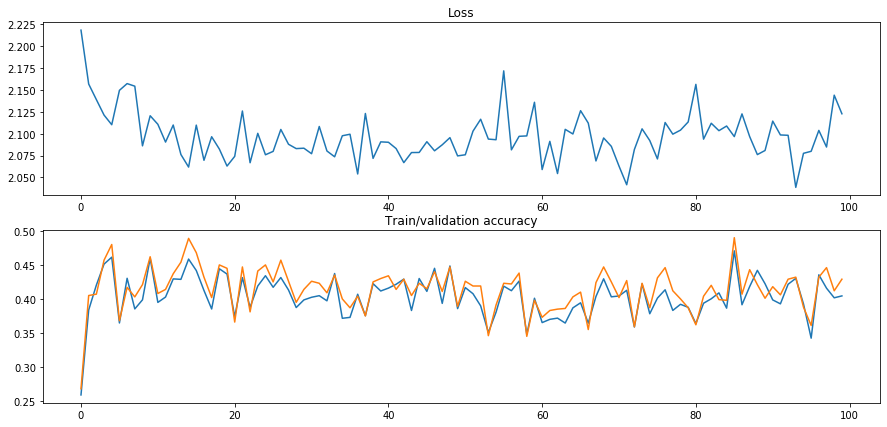

In [39]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [40]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.641000
